In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

from relu import ReLU
from saturated_relu import SaturatedReLU
from logistic4 import Logistic4
from logistic5 import Logistic5
from rectified_logistic import RectifiedLogistic

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
dest = "/home/vishu/logs/rats-example.log"
logging.basicConfig(
    format=FORMAT,
    level=logging.INFO,
    handlers=[
        logging.FileHandler(dest, mode="w"),
        logging.StreamHandler()
    ],
    force=True
)


In [2]:
dir = "/home/vishu/repos/hbmep-paper/reports/paper/rats/J_RCML_000/link-comparison/"
data = "numpyro_data.nc"

model_dir = "rectified-logistic"
src = os.path.join(dir, model_dir, "Biceps", data)
rectified_logistic = az.from_netcdf(src)

model_dir = "logistic5"
src = os.path.join(dir, model_dir, "Biceps", data)
logistic5 = az.from_netcdf(src)

model_dir = "logistic4"
src = os.path.join(dir, model_dir, "Biceps", data)
logistic4 = az.from_netcdf(src)

model_dir = "saturated-relu"
src = os.path.join(dir, model_dir, "Biceps", data)
saturated_relu = az.from_netcdf(src)

model_dir = "relu"
src = os.path.join(dir, model_dir, "Biceps", data)
relu = az.from_netcdf(src)


In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/rats/J_RCML_000/config.toml"
config = Config(toml_path=toml_path)
config.FEATURES = ["participant", "compound_position"]
config.RESPONSE = ["LBiceps"]
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "link-comparison", "rectified-logistic", "Biceps")
config.MCMC_PARAMS["num_warmup"] = 5000
config.MCMC_PARAMS["num_samples"] = 1000

r = ReLU(config=config)
sl = SaturatedReLU(config=config)
l4 = Logistic4(config=config)
l5 = Logistic5(config=config)
rl = RectifiedLogistic(config=config)

src = "/home/vishu/data/hbmep-processed/J_RCML_000/data.csv"
df = pd.read_csv(src)
df, encoder_dict = r.load(df=df)


2023-12-12 18:41:21,627 - hbmep.model.baseline - INFO - Initialized relu
2023-12-12 18:41:21,628 - hbmep.model.baseline - INFO - Initialized saturated_relu
2023-12-12 18:41:21,628 - hbmep.model.baseline - INFO - Initialized logistic_4
2023-12-12 18:41:21,629 - hbmep.model.baseline - INFO - Initialized logistic5
2023-12-12 18:41:21,629 - hbmep.model.baseline - INFO - Initialized rectified_logistic
2023-12-12 18:41:21,644 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/rats/J_RCML_000/link-comparison/rectified-logistic/Biceps
2023-12-12 18:41:21,644 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/rats/J_RCML_000/link-comparison/rectified-logistic/Biceps
2023-12-12 18:41:21,645 - hbmep.dataset.core - WARNING - Total non-positive observations: 0
2023-12-12 18:41:21,646 - hbmep.dataset.core - WARNING - Total missing observations: 0
2023-12-12 18:41:21,646 - hbmep.dataset.core - INFO - Proces

In [4]:
prediction_df = r.make_prediction_dataset(df=df, num=500)


2023-12-12 18:41:21,670 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


In [5]:
def _get_posterior(numpyro_data):
    ps = {
        u: numpyro_data.posterior[u].to_numpy() for u in numpyro_data.posterior.data_vars
    }
    ps = {
        u: v.reshape(-1, *v.shape[2:]) for u, v in ps.items()
    }
    return ps


In [6]:
relu_ps = _get_posterior(relu)
saturated_relu_ps = _get_posterior(saturated_relu)
logistic4_ps = _get_posterior(logistic4)
logistic5_ps = _get_posterior(logistic5)
rectified_logistic_ps = _get_posterior(rectified_logistic)


In [7]:
relu_ppd = r.predict(df=prediction_df, posterior_samples=relu_ps)
saturated_relu_ppd = sl.predict(df=prediction_df, posterior_samples=saturated_relu_ps)
logistic4_ppd = l4.predict(df=prediction_df, posterior_samples=logistic4_ps)
logistic5_ppd = l5.predict(df=prediction_df, posterior_samples=logistic5_ps)
rectified_logistic_ppd = rl.predict(df=prediction_df, posterior_samples=rectified_logistic_ps)


2023-12-12 18:43:11,160 - hbmep.utils.utils - INFO - func:predict took: 1 min and 40.12 sec
2023-12-12 18:44:51,713 - hbmep.utils.utils - INFO - func:predict took: 1 min and 40.55 sec
2023-12-12 18:46:30,975 - hbmep.utils.utils - INFO - func:predict took: 1 min and 39.26 sec
2023-12-12 18:48:14,232 - hbmep.utils.utils - INFO - func:predict took: 1 min and 43.26 sec
2023-12-12 18:50:00,973 - hbmep.utils.utils - INFO - func:predict took: 1 min and 46.74 sec


In [8]:
posts = [relu_ppd, saturated_relu_ppd, logistic4_ppd, logistic5_ppd, rectified_logistic_ppd]
obss = [ppd[site.obs] for ppd in posts]
hpdis = [hpdi(obs, prob=.95) for obs in obss]


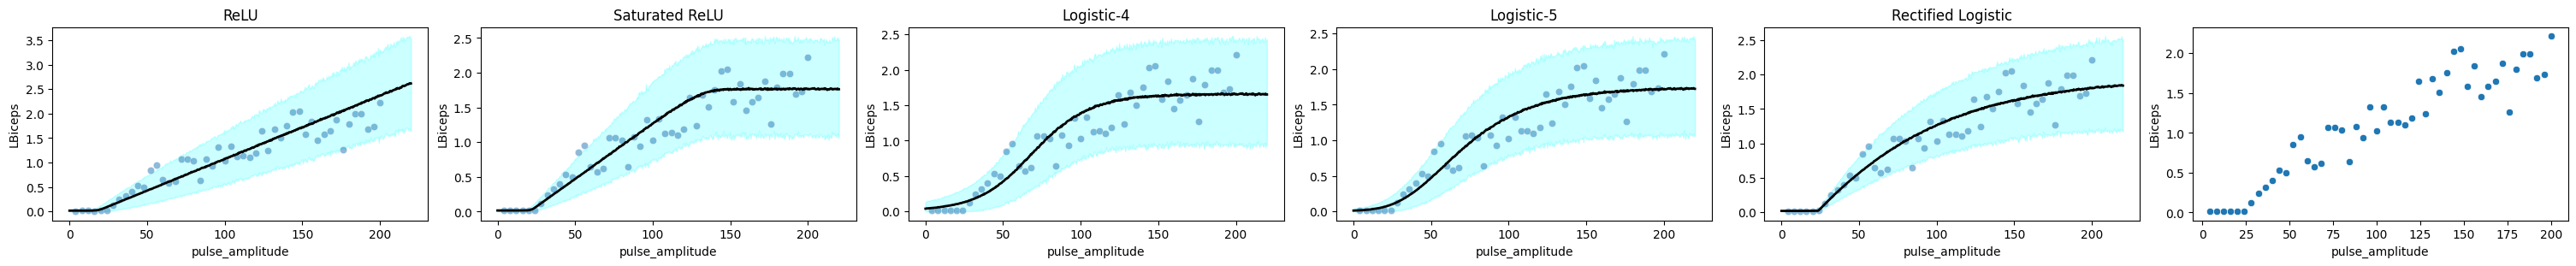

In [11]:
c = (4, 10)
ind = df[r.features].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()
ind = prediction_df[r.features].apply(tuple, axis=1).isin([c])
temp_prediction_df = prediction_df[ind].reset_index(drop=True).copy()

fns = ["ReLU", "Saturated ReLU", "Logistic-4", "Logistic-5", "Rectified Logistic"]
n_fns = len(fns)

nrows, ncols = 1, n_fns + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)

i = 0
for _ in range(n_fns):
    curr_ppd = posts[i]
    ax = axes[i // ncols, i % ncols]
    ax.fill_between(
        temp_prediction_df[r.intensity],
        hpdis[i][0, ind, 0],
        hpdis[i][1, ind, 0],
        color="cyan",
        alpha=.2
    )
    sns.scatterplot(x=temp_df[r.intensity], y=temp_df[r.response[0]], ax=ax, alpha=.5)
    sns.lineplot(x=temp_prediction_df[r.intensity], y=np.array(curr_ppd[site.obs])[:, ind, 0].mean(axis=0), ax=ax, color="black", lw=2)

    ax.set_title(fns[i])
    i += 1

ax = axes[0, -1]
sns.scatterplot(x=temp_df[r.intensity], y=temp_df[r.response[0]], ax=ax)


fig.savefig("/home/vishu/comparison.png", dpi=600)


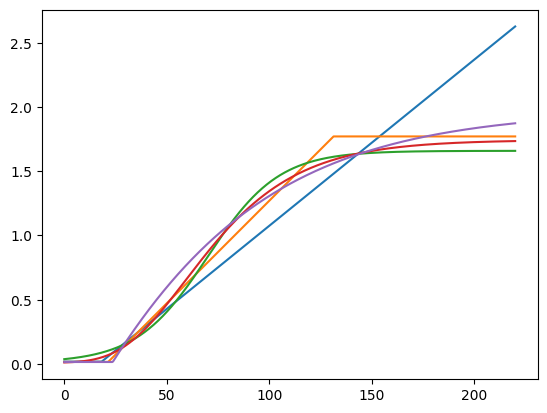

In [81]:
x = temp_prediction_df[r.intensity].values

params = [
    (relu_ps, [site.a, site.b, site.L], F.relu),
    (saturated_relu_ps, [site.a, site.b, site.L, site.H], F.saturated_relu),
    (logistic4_ps, [site.a, site.b, site.L, site.H], F.logistic4),
    (logistic5_ps, [site.a, site.b, site.v, site.L, site.H], F.logistic5),
    (rectified_logistic_ps, [site.a, site.b, site.v, site.L, site.ell, site.H], F.rectified_logistic)
]

params = (
    ((
        np.array(
            [ps[param].mean(axis=0)[*c, 0]] * temp_prediction_df[r.intensity].shape[0]
        ) for param in sites
    ), fn) for (ps, sites, fn) in params
)

ys = \
    (
        fn(x, *args) for (args, fn) in params
    )

ys = list(ys)

for y in ys:
    sns.lineplot(x=x, y=y)


In [83]:
rats_dict = {
    "Rectified Logistic": rectified_logistic,
    "Logistic-5": logistic5,
    "Logistic-4": logistic4,
    "Saturated ReLU": saturated_relu,
    "ReLU": relu
}

rats_df = az.compare(rats_dict)
rats_df


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the 

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Rectified Logistic,0,6083.246586,942.892821,0.000000,9.403420e-01,168.407586,0.000000,True,log
Logistic-5,1,5434.647303,864.559395,648.599283,4.247776e-09,162.163736,35.601116,True,log
Saturated ReLU,2,5346.925021,888.028728,736.321565,2.319231e-02,167.161784,39.936593,True,log
Logistic-4,3,5018.669543,836.597595,1064.577043,2.809627e-02,158.338566,47.988149,True,log
ReLU,4,4407.102781,749.743434,1676.143805,8.369447e-03,168.742609,55.793789,True,log


In [84]:
dir = "/home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison"
data = "numpyro_data.nc"

model_dir = "rectified-logistic"
src = os.path.join(dir, model_dir, data)
rectified_logistic = az.from_netcdf(src)

model_dir = "logistic5"
src = os.path.join(dir, model_dir, data)
logistic5 = az.from_netcdf(src)

model_dir = "logistic4"
src = os.path.join(dir, model_dir, data)
logistic4 = az.from_netcdf(src)

# model_dir = "saturated-relu"
# src = os.path.join(dir, model_dir, data)
# saturated_relu = az.from_netcdf(src)

model_dir = "relu"
src = os.path.join(dir, model_dir, data)
relu = az.from_netcdf(src)

tms_dict = {
    "Rectified Logistic": rectified_logistic,
    "Logistic-5": logistic5,
    "Logistic-4": logistic4,
    # "Saturated ReLU": saturated_relu,
    "ReLU": relu
}

tms_df = az.compare(tms_dict)
tms_df


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Rectified Logistic,0,22168.643254,881.632869,0.000000,0.529549,218.355073,0.000000,True,log
Logistic-5,1,22150.657948,845.304095,17.985307,0.095715,217.981056,19.339581,True,log
Logistic-4,2,22096.578792,848.946594,72.064463,0.283603,218.583805,26.618477,True,log
ReLU,3,21703.813221,729.214069,464.830034,0.091133,220.971542,37.975662,True,log


In [85]:
dir = "/home/vishu/repos/hbmep-paper/reports/paper/intraoperative/link-comparison/"
data = "numpyro_data.nc"

model_dir = "rectified-logistic"
src = os.path.join(dir, model_dir, data)
rectified_logistic = az.from_netcdf(src)

model_dir = "logistic-5"
src = os.path.join(dir, model_dir, data)
logistic5 = az.from_netcdf(src)

model_dir = "logistic-4"
src = os.path.join(dir, model_dir, data)
logistic4 = az.from_netcdf(src)

model_dir = "saturated-relu"
src = os.path.join(dir, model_dir, data)
saturated_relu = az.from_netcdf(src)

model_dir = "relu"
src = os.path.join(dir, model_dir, data)
relu = az.from_netcdf(src)

intraop_dict = {
    "Rectified Logistic": rectified_logistic,
    "Logistic-5": logistic5,
    "Logistic-4": logistic4,
    "Saturated ReLU": saturated_relu,
    "ReLU": relu
}

intraop_df = az.compare(intraop_dict)
intraop_df


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the 

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Rectified Logistic,0,4995.711311,566.378657,0.000000,7.130480e-01,164.883070,0.000000,True,log
Logistic-5,1,4965.642683,544.324477,30.068628,2.219177e-01,164.436245,21.770728,True,log
Logistic-4,2,4906.062951,542.106480,89.648360,4.534498e-18,164.428601,26.210829,True,log
Saturated ReLU,3,4693.075731,651.363120,302.635579,2.023208e-02,163.983580,32.565164,True,log
ReLU,4,4436.986754,481.483627,558.724557,4.480219e-02,166.912318,46.988434,True,log


In [122]:
compare_dfs = [rats_df, tms_df, intraop_df]
compare_dfs_labels = ["Rats", "TMS", "Intraoperative"]


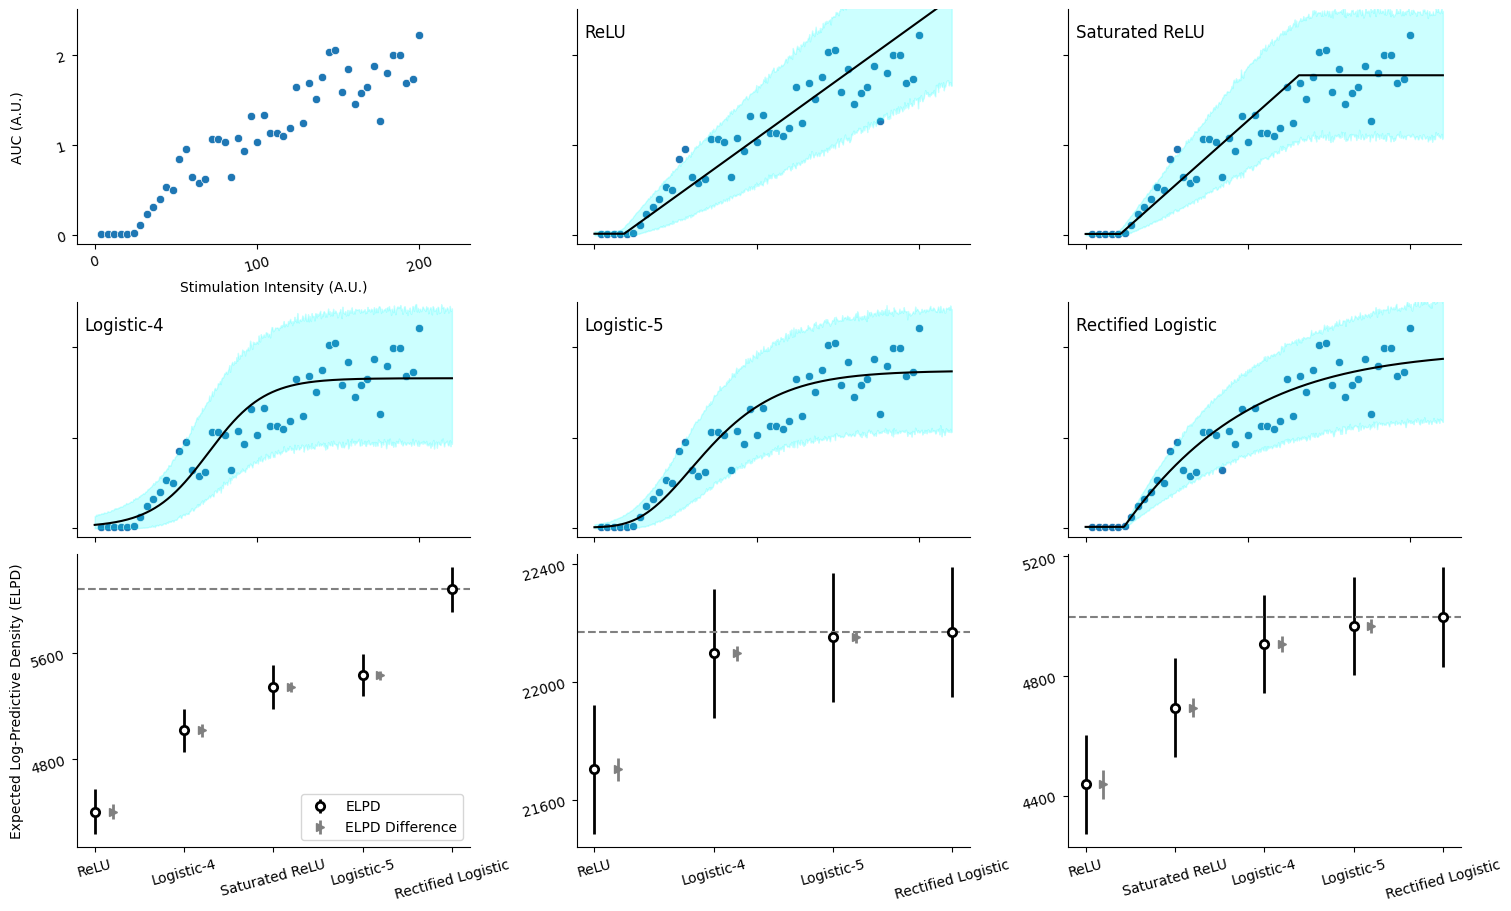

In [248]:
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1., 1., 1.25])

counter = 0
for i in range(2):
    for j in range(3):
        ax = axes[i, j]

        if (i, j) == (0, 0):
            sns.scatterplot(x=temp_df[r.intensity], y=temp_df[r.response[0]], ax=ax)
            counter += 1
            continue

        # sns.lineplot(x=x, y=np.array(curr_ppd[site.obs])[:, ind, 0].mean(axis=0), ax=ax, color="black")
        y = ys[counter - 1]
        sns.lineplot(x=temp_prediction_df[r.intensity], y=y, ax=ax, color="black")
        sns.scatterplot(x=temp_df[r.intensity], y=temp_df[r.response[0]], ax=ax)
        curr_ppd = posts[counter - 1]
        ax.fill_between(
            temp_prediction_df[r.intensity],
            hpdis[counter - 1][0, ind, 0],
            hpdis[counter - 1][1, ind, 0],
            color="cyan",
            alpha=.2
        )
        ax.set_title(fns[counter - 1], y=1., pad=-20, loc="left", x=0.02)
        counter += 1

for (j, compare_df) in enumerate(compare_dfs):
    ax = axes[2, j]
    y = compare_df.elpd_loo
    x = compare_df.index.values
    diff, dse = compare_df.elpd_diff, compare_df.dse
    x, y, diff, dse = zip(*sorted(zip(x, y, diff, dse), key=lambda x: x[1]))
    xvals = np.array([i for i in range(len(x))])
    yerr = compare_df.se
    ax.errorbar(x=xvals, y=y, fmt="o", yerr=yerr, markeredgecolor="black", markerfacecolor="white", ecolor="black", label="ELPD", lw=2, markeredgewidth=2)
    ax.set_xticks(xvals)
    ax.set_xticklabels(x, rotation=15)
    xvals = xvals[:-1]
    diff, dse = diff[:-1], dse[:-1]
    ax.errorbar(x=xvals + .2, y=y[:-1], fmt=">", yerr=dse, color="grey", barsabove=True, label="ELPD Difference", lw=2)
    ax.axhline(y=y[-1], linestyle="--", color="grey")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.legend(loc="lower right")
    if j: ax.get_legend().remove()

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=False,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        ax.sharex(axes[0, 0])
        ax.sharey(axes[0, 0])

ax = axes[0, 0]
# ax.set_xlim(right=210)
ax.set_ylim(top=2.5)
ax.set_xticks([0, 100, 200])
ax.set_yticks([0., 1., 2.])
ax.tick_params(
    axis='both',
    which='both',
    labelleft=True,
    labelbottom=True,
)
ax.set_xlabel("Stimulation Intensity (A.U.)")
ax.set_ylabel("AUC (A.U.)")

for j in range(ncols):
    ax = axes[2, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        labelleft=True,
        labelbottom=True
    )
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

ax = axes[2, 0]
ax.set_ylabel("Expected Log-Predictive Density (ELPD)")

fig.align_xlabels()
fig.align_ylabels()

dest = "/home/vishu/repos/hbmep-paper/notebooks/paper/rats/J_RCML_000/link-comparison/result.png"
fig.savefig(dest, dpi=600)




In [51]:
relu_params

<generator object <genexpr> at 0x7fa92047ee30>

In [20]:
from hbmep.model import functional as F


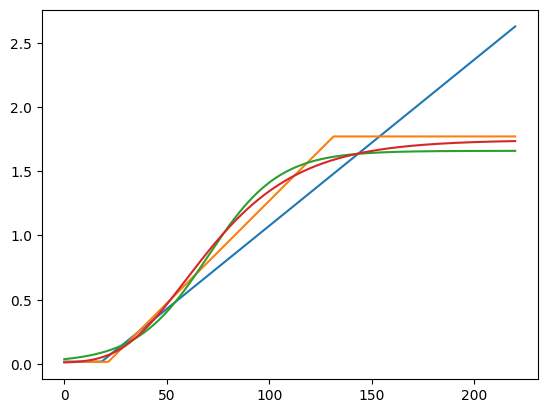

In [23]:
x = temp_prediction_df[r.intensity].values


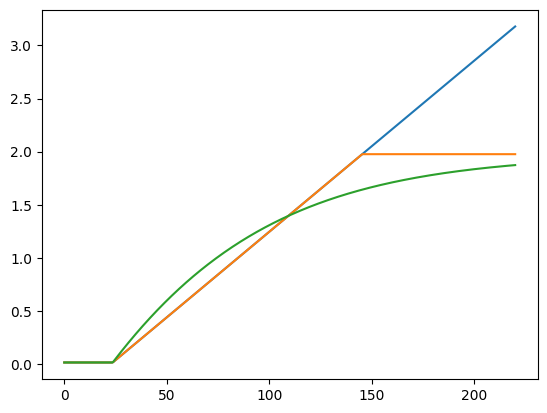

In [44]:
len(list(ys[0]))

2

In [47]:
relu_params = (site.a, site.b, site.L)
relu_params = (
    np.array(
        [relu_ps[param].mean(axis=0)[*c, 0]] * temp_prediction_df[r.intensity].shape[0]
    ) for param in relu_params
)

saturated_relu_params = (site.a, site.b, site.L, site.H)



In [17]:
ys = [(relu_ps, relu_params), (saturated_relu_ps, saturated_relu_params)]


NameError: name 'relu_params' is not defined

In [44]:
temp_prediction_df[r.intensity].shape

(500,)

In [ ]:
temp_prediction_df